<a href="https://colab.research.google.com/github/Hossain-MD-Rafat/depression_prediction/blob/main/final_project_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,  GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, classification_report
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import time

In [ ]:
train_path = os.path.expanduser('~/Downloads/train.csv')
test_path = os.path.expanduser('~/Downloads/test.csv')
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [ ]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [ ]:
print(f"Training data set missing values = \n{train_data.isnull().sum()}")
print(f"Test data set missing values = \n{test_data.isnull().sum()}")


Training data set missing values = 
id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtyp

In [ ]:
# Check for duplicates in the training dataset
train_duplicates = train_data[train_data.duplicated()]
if not train_duplicates.empty:
    print(f"Training dataset has {len(train_duplicates)} duplicate rows.")
else:
    print("No duplicate rows in the training dataset.")

# Check for duplicates in the test dataset
test_duplicates = test_data[test_data.duplicated()]
if not test_duplicates.empty:
    print(f"Test dataset has {len(test_duplicates)} duplicate rows.")
else:
    print("No duplicate rows in the test dataset.")


No duplicate rows in the training dataset.
No duplicate rows in the test dataset.


In [ ]:
# Impute 'Profession' and 'Dietary Habits' with mode
train_data['Profession'].fillna(train_data['Profession'].mode()[0], inplace=True)
train_data['Dietary Habits'].fillna(train_data['Dietary Habits'].mode()[0], inplace=True)

test_data['Profession'].fillna(test_data['Profession'].mode()[0], inplace=True)
test_data['Dietary Habits'].fillna(test_data['Dietary Habits'].mode()[0], inplace=True)

# Replace missing values in 'Degree' with 'Unknown'
train_data['Degree'].fillna('Unknown', inplace=True)
test_data['Degree'].fillna('Unknown', inplace=True)


In [ ]:
# Impute 'CGPA' and 'Work Pressure' with median
train_data['CGPA'].fillna(train_data['CGPA'].median(), inplace=True)
train_data['Work Pressure'].fillna(train_data['Work Pressure'].median(), inplace=True)

test_data['CGPA'].fillna(test_data['CGPA'].median(), inplace=True)
test_data['Work Pressure'].fillna(test_data['Work Pressure'].median(), inplace=True)

# Impute 'Financial Stress' with mean
train_data['Financial Stress'].fillna(train_data['Financial Stress'].mean(), inplace=True)
test_data['Financial Stress'].fillna(test_data['Financial Stress'].mean(), inplace=True)


In [ ]:
# Impute 'Academic Pressure' based on 'Degree'
train_data['Academic Pressure'] = train_data.groupby('Degree')['Academic Pressure'].transform(
    lambda x: x.fillna(x.median())
)

test_data['Academic Pressure'] = test_data.groupby('Degree')['Academic Pressure'].transform(
    lambda x: x.fillna(x.median())
)

# Impute 'Study Satisfaction' based on 'Profession'
train_data['Study Satisfaction'] = train_data.groupby('Profession')['Study Satisfaction'].transform(
    lambda x: x.fillna(x.median())
)

test_data['Study Satisfaction'] = test_data.groupby('Profession')['Study Satisfaction'].transform(
    lambda x: x.fillna(x.median())
)


In [ ]:
# Median imputation for 'Academic Pressure'
train_data['Academic Pressure'].fillna(train_data['Academic Pressure'].median(), inplace=True)
test_data['Academic Pressure'].fillna(test_data['Academic Pressure'].median(), inplace=True)


In [ ]:
# Group-based median imputation for 'Study Satisfaction'
train_data['Study Satisfaction'] = train_data.groupby('Working Professional or Student')['Study Satisfaction'].transform(
    lambda x: x.fillna(x.median())
)
test_data['Study Satisfaction'] = test_data.groupby('Working Professional or Student')['Study Satisfaction'].transform(
    lambda x: x.fillna(x.median())
)

# Group-based median imputation for 'Job Satisfaction'
train_data['Job Satisfaction'] = train_data.groupby('Profession')['Job Satisfaction'].transform(
    lambda x: x.fillna(x.median())
)
test_data['Job Satisfaction'] = test_data.groupby('Profession')['Job Satisfaction'].transform(
    lambda x: x.fillna(x.median())
)


In [ ]:
# Impute missing 'Job Satisfaction' values in the test dataset with the median
test_data['Job Satisfaction'].fillna(test_data['Job Satisfaction'].median(), inplace=True)


In [ ]:
if train_data.isnull().sum().sum() > 0:
    print(f"Training data set missing values = \n{train_data.isnull().sum()}")
else:
    print("No missing values in the training dataset.")

if test_data.isnull().sum().sum() > 0:
    print(f"Test data set missing values = \n{test_data.isnull().sum()}")
else:
    print("No missing values in the test dataset.")


No missing values in the training dataset.
No missing values in the test dataset.


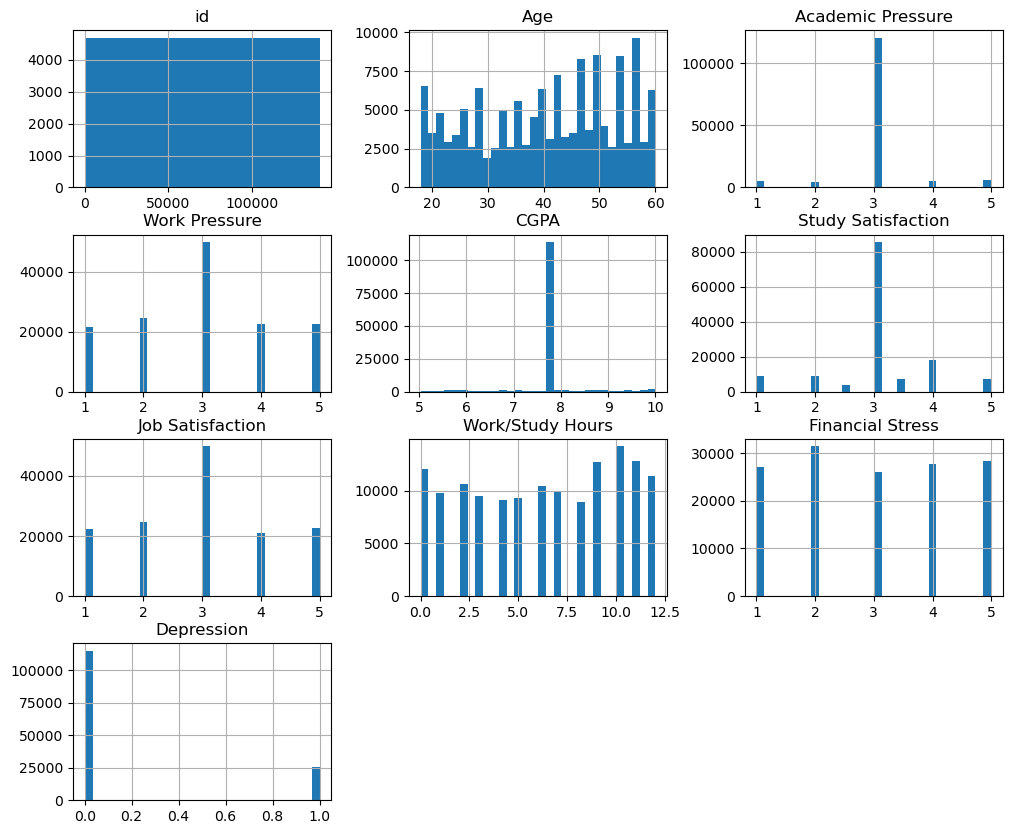

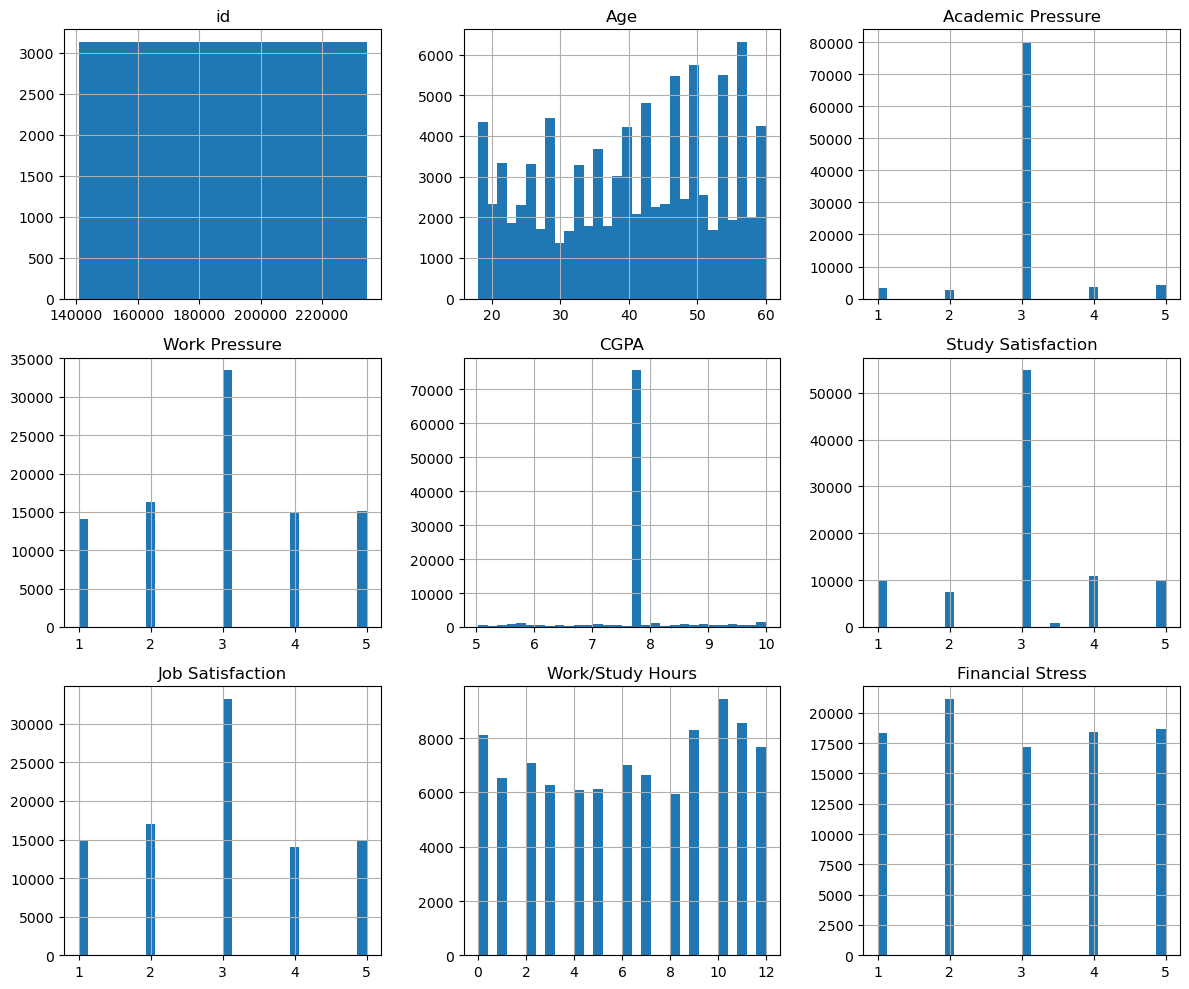

In [ ]:
import matplotlib.pyplot as plt

# Plot histograms for numerical features
train_data.hist(figsize=(12, 10), bins=30)
test_data.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()


In [ ]:
# Identify numerical columns in the dataset
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

# Calculate Q1, Q3, and IQR
Q1 = train_data[numerical_columns].quantile(0.25)
Q3 = train_data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = ((train_data[numerical_columns] < (Q1 - 1.5 * IQR)) |
            (train_data[numerical_columns] > (Q3 + 1.5 * IQR)))

# Count the number of outliers per column
outlier_counts = outliers.sum()

# Display the results
print("Number of outliers detected in each numerical column:")
print(outlier_counts)

# Identify columns with the most outliers
most_outliers = outlier_counts[outlier_counts > 0].sort_values(ascending=False)
print("\nColumns with the most outliers:")
print(most_outliers)


Number of outliers detected in each numerical column:
id                        0
Age                       0
Academic Pressure     20441
Work Pressure             0
CGPA                  27629
Study Satisfaction    55056
Job Satisfaction          0
Work/Study Hours          0
Financial Stress          0
Depression            25567
dtype: int64

Columns with the most outliers:
Study Satisfaction    55056
CGPA                  27629
Depression            25567
Academic Pressure     20441
dtype: int64


In [ ]:
# Capping outliers for selected columns
for column in ['Study Satisfaction', 'CGPA', 'Academic Pressure']:
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    train_data[column] = train_data[column].clip(lower=lower_bound, upper=upper_bound)


In [ ]:
# Identify numerical columns in the dataset
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

# Calculate Q1, Q3, and IQR
Q1 = train_data[numerical_columns].quantile(0.25)
Q3 = train_data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = ((train_data[numerical_columns] < (Q1 - 1.5 * IQR)) |
            (train_data[numerical_columns] > (Q3 + 1.5 * IQR)))

# Count the number of outliers per column
outlier_counts = outliers.sum()

# Display the results
print("Number of outliers detected in each numerical column:")
print(outlier_counts)

# Identify columns with the most outliers
most_outliers = outlier_counts[outlier_counts > 0].sort_values(ascending=False)
print("\nColumns with the most outliers:")
print(most_outliers)


Number of outliers detected in each numerical column:
id                        0
Age                       0
Academic Pressure         0
Work Pressure             0
CGPA                      0
Study Satisfaction        0
Job Satisfaction          0
Work/Study Hours          0
Financial Stress          0
Depression            25567
dtype: int64

Columns with the most outliers:
Depression    25567
dtype: int64


In [ ]:
# List of columns to drop
columns_to_drop = ['CGPA', 'Academic Pressure', 'Study Satisfaction']

# Drop the columns
train_data_cleaned = train_data.drop(columns=columns_to_drop)

# Verify the remaining columns
print("Columns after dropping specific columns:")
print(train_data_cleaned.columns)

Columns after dropping specific columns:
Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Work Pressure',
       'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')


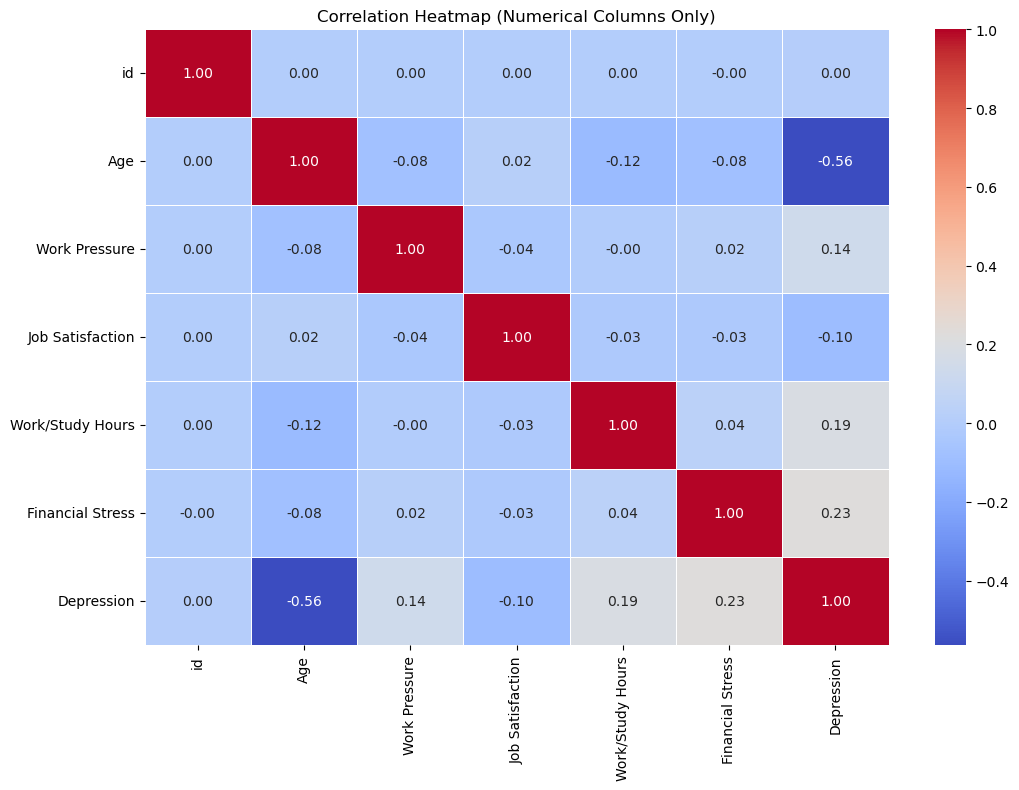

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
numerical_columns = train_data_cleaned.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Columns Only)")
plt.show()


In [ ]:
# Pairplot to visualize relationships between features
sns.pairplot(train_data_cleaned, hue='Depression')  # Use the target column for coloring
plt.show()


In [ ]:
from scipy.stats import zscore
import pandas as pd

# Step 1: Select only numerical columns
numerical_columns = train_data.select_dtypes(include=['float64', 'int64'])

# Step 2: Calculate Z-scores for each column
z_scores = numerical_columns.apply(zscore)

# Step 3: Detect anomalies (Z-scores > 3 or < -3)
anomalies = (z_scores.abs() > 3).sum()

# Step 4: Display detected anomalies per column
print("Number of anomalies detected in each numerical column:")
print(anomalies)


Number of anomalies detected in each numerical column:
id                    0
Age                   0
Academic Pressure     0
Work Pressure         0
CGPA                  0
Study Satisfaction    0
Job Satisfaction      0
Work/Study Hours      0
Financial Stress      0
Depression            0
dtype: int64


In [ ]:
print("Summary Statistics of Numerical Columns:")
train_data.describe()

Summary Statistics of Numerical Columns:


,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,140700.0,140700.000000,1.407000e+05,140700.0,140700.00000,140700.000000,140700.000000,140700.000000
mean,70349.500000,40.388621,3.0,2.999197,7.770000e+00,3.0,2.97946,6.252679,2.988983,0.181713
std,40616.735775,12.384099,0.0,1.258598,1.306337e-11,0.0,1.26792,3.853615,1.413613,0.385609
min,0.000000,18.000000,3.0,1.000000,7.770000e+00,3.0,1.00000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,3.0,2.000000,7.770000e+00,3.0,2.00000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.0,3.000000,7.770000e+00,3.0,3.00000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,3.0,4.000000,7.770000e+00,3.0,4.00000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,3.0,5.000000,7.770000e+00,3.0,5.00000,12.000000,5.000000,1.000000


In [ ]:
print("Summary Statistics of Numerical Columns:")
train_data_cleaned.describe()

Summary Statistics of Numerical Columns:


,id,Age,Work Pressure,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,140700.000000,140700.00000,140700.000000,140700.000000,140700.000000
mean,70349.500000,40.388621,2.999197,2.97946,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.258598,1.26792,3.853615,1.413613,0.385609
min,0.000000,18.000000,1.000000,1.00000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.00000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.00000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.00000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.00000,12.000000,5.000000,1.000000


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import time

# Step 1: Define Features (X) and Target (y)
# Drop 'id' and target column 'Depression'
X = train_data_cleaned.drop(columns=['Depression', 'id'])
y = train_data_cleaned['Depression']

# Step 2: Encode Categorical Columns
# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Encode categorical features using OrdinalEncoder
encoder = OrdinalEncoder()
X[categorical_columns] = encoder.fit_transform(X[categorical_columns])

# Step 3: Scale Numerical Features for SVC
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the entire dataset

# Step 4: Split the Dataset (80%-20% split on scaled features)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Build Models
# Model 1: Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)  # Limited depth for computational efficiency
start_time = time.time()
dt_model.fit(X_train, y_train)
end_time = time.time()
print(f"\nDecision Tree Training Time: {end_time - start_time:.2f} seconds")
y_pred_dt = dt_model.predict(X_test)

# Model 2: Random Forest
rf_model = RandomForestClassifier(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42)  # Fewer estimators, parallelized
start_time = time.time()
rf_model.fit(X_train, y_train)
end_time = time.time()
print(f"Random Forest Training Time: {end_time - start_time:.2f} seconds")
y_pred_rf = rf_model.predict(X_test)

# Model 3: Support Vector Classifier (SVC)
svc_model = SVC(kernel='linear', probability=True, random_state=42)  # Linear kernel for faster computation
start_time = time.time()
svc_model.fit(X_train, y_train)  # Use scaled features
end_time = time.time()
print(f"SVC Training Time: {end_time - start_time:.2f} seconds")
y_pred_svc = svc_model.predict(X_test)

# Step 6: Evaluate Models
print("\nDecision Tree Performance:")
print(classification_report(y_test, y_pred_dt))

print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))

print("\nSupport Vector Classifier Performance:")
print(classification_report(y_test, y_pred_svc))

# Step 7: Cross-Validation to Check Generalization
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_dt = cross_val_score(dt_model, X_scaled, y, cv=cv, scoring='accuracy', n_jobs=-1)
cv_rf = cross_val_score(rf_model, X_scaled, y, cv=cv, scoring='accuracy', n_jobs=-1)
cv_svc = cross_val_score(svc_model, X_scaled, y, cv=cv, scoring='accuracy', n_jobs=-1)

print("\nCross-Validation Scores (5-Fold):")
print(f"Decision Tree Accuracy: {np.mean(cv_dt):.4f}")
print(f"Random Forest Accuracy: {np.mean(cv_rf):.4f}")
print(f"Support Vector Classifier Accuracy: {np.mean(cv_svc):.4f}")

# Step 8: Compare Training and Testing Accuracy to Check Overfitting
print("\nTraining Accuracy:")
print(f"Decision Tree: {accuracy_score(y_train, dt_model.predict(X_train)):.4f}")
print(f"Random Forest: {accuracy_score(y_train, rf_model.predict(X_train)):.4f}")
print(f"SVC: {accuracy_score(y_train, svc_model.predict(X_train)):.4f}")

print("\nTesting Accuracy:")
print(f"Decision Tree: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Random Forest: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"SVC: {accuracy_score(y_test, y_pred_svc):.4f}")


Categorical columns: Index(['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],
      dtype='object')

Decision Tree Training Time: 0.36 seconds
Random Forest Training Time: 0.82 seconds
SVC Training Time: 325.27 seconds

Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     23027
           1       0.77      0.79      0.78      5113

    accuracy                           0.92     28140
   macro avg       0.86      0.87      0.87     28140
weighted avg       0.92      0.92      0.92     28140


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     23027
           1       0.81      0.78      0.80      5113

    accuracy                           0.93     28140
   macro a

In [ ]:
# Implement SGD Classifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

# Configure SGD for Logistic Regression (log_loss for classification)
sgd_model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)

# Train the model
sgd_model.fit(X_train, y_train)

# Make predictions
y_pred_sgd = sgd_model.predict(X_test)

# Evaluate SGD Classifier
print("\nSGD Classifier Performance:")
print(classification_report(y_test, y_pred_sgd))
print(f"Accuracy: {accuracy_score(y_test, y_pred_sgd):.4f}")

# Compare Training and Testing Accuracy
train_accuracy = accuracy_score(y_train, sgd_model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred_sgd)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")



SGD Classifier Performance:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     23027
           1       0.83      0.75      0.79      5113

    accuracy                           0.93     28140
   macro avg       0.89      0.86      0.87     28140
weighted avg       0.92      0.93      0.92     28140

Accuracy: 0.9264
Training Accuracy: 0.9265
Testing Accuracy: 0.9264


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Initialize GridSearchCV for Decision Tree
dt_grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit the Grid Search
dt_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}

# Initialize RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=20,  # Number of random combinations to try
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit the Randomized Search
rf_random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Random Forest Parameters:", rf_random_search.best_params_)
print("Best Random Forest Accuracy:", rf_random_search.best_score_)


Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 15}
Best Random Forest Accuracy: 0.9298862828713574


In [ ]:
'''
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid for SVC
svc_param_grid = {
    'C': [0.1, 1],               # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel types
    'gamma': ['scale']       # Kernel coefficient
}

# Initialize GridSearchCV for SVC
svc_grid_search = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=svc_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit the Grid Search
svc_grid_search.fit(X_train, y_train)

# Print Best Parameters and Accuracy
print("Best SVC Parameters:", svc_grid_search.best_params_)
print("Best SVC Cross-Validation Accuracy:", svc_grid_search.best_score_)
'''

'\nfrom sklearn.svm import SVC\nfrom sklearn.model_selection import GridSearchCV\n\n# Define parameter grid for SVC\nsvc_param_grid = {\n    \'C\': [0.1, 1],               # Regularization parameter\n    \'kernel\': [\'linear\', \'rbf\'],  # Kernel types\n    \'gamma\': [\'scale\']       # Kernel coefficient\n}\n\n# Initialize GridSearchCV for SVC\nsvc_grid_search = GridSearchCV(\n    estimator=SVC(probability=True, random_state=42),\n    param_grid=svc_param_grid,\n    scoring=\'accuracy\',\n    cv=5,\n    n_jobs=-1\n)\n\n# Fit the Grid Search\nsvc_grid_search.fit(X_train, y_train)\n\n# Print Best Parameters and Accuracy\nprint("Best SVC Parameters:", svc_grid_search.best_params_)\nprint("Best SVC Cross-Validation Accuracy:", svc_grid_search.best_score_)\n'

In [ ]:
print("Best Decision Tree Parameters:", dt_grid_search.best_params_)
# Example Output: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}

print("Best Random Forest Parameters:", rf_random_search.best_params_)
# Example Output: {'n_estimators': 100, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5}

#print("Best SVC Parameters:", svc_grid_search.best_params_)
# Example Output: {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}


Best Decision Tree Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 15}


In [ ]:
# Retrieve best models
best_dt_model = dt_grid_search.best_estimator_
best_rf_model = rf_random_search.best_estimator_
#best_svc_model = svc_grid_search.best_estimator_


In [ ]:
print("Decision Tree Test Accuracy:", accuracy_score(y_test, best_dt_model.predict(X_test)))
# Example Output: Decision Tree Test Accuracy: 0.85

print("Random Forest Test Accuracy:", accuracy_score(y_test, best_rf_model.predict(X_test)))
# Example Output: Random Forest Test Accuracy: 0.89

#print("SVC Test Accuracy:", accuracy_score(y_test, best_svc_model.predict(X_test)))
# Example Output: SVC Test Accuracy: 0.87


Decision Tree Test Accuracy: 0.9200071073205401
Random Forest Test Accuracy: 0.9283226723525231


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import time

# List of models to evaluate
models = {
    "Decision Tree": best_dt_model,
    "Random Forest": best_rf_model,
}

# Dictionary to store results
results = []

# Evaluate each model
for model_name, model in models.items():
    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Measure testing time
    start_time = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_time

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, "predict_proba") else "N/A"
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
        "ROC-AUC": roc_auc,
        "Training Time (s)": train_time,
        "Testing Time (s)": test_time
    })

# Create a DataFrame to compare results
import pandas as pd
results_df = pd.DataFrame(results)

# Display results
print("\nModel Comparison Results:")
print(results_df)



Model Comparison Results:
           Model  Accuracy  Precision    Recall  F1-Score  ROC-AUC  \
0  Decision Tree  0.920007   0.920543  0.920007  0.920263  0.95079   
1  Random Forest  0.928323   0.927318  0.928323  0.927743  0.96702   

   Training Time (s)  Testing Time (s)  
0           0.285013          0.002798  
1          10.260847          0.474782  
